In [ ]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(a, eps0, tau, t_e):
    return eps0 * np.exp(-(a - t_e) / tau)

# def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta):
#     from scipy.integrate import quad
#     import numpy as np

#     if a < t_e - delta:
#         return hill_survival_function(a, mu_ub, mu_lb, K, m)
    
#     elif t_e - delta <= a <= t_e:
#         return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, t_e) * quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, delta-(t_e-a))[0])
    
#     else:
#         return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, t_e) * quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), a-t_e, a-t_e+delta)[0])

# def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta):
#     import numpy as np

#     return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta) for a in ages])

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):

    if a < t_e - delta:
        return hill_survival_function(a, mu_ub, mu_lb, K, m)
    elif t_e - delta <= a <= t_e:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, delta-(t_e-a))
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)
    else:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), a-t_e, a-t_e+delta)
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau) for a in ages])

# def neg_ll_hill_with_dip(params, ages, survivors, totals):
#     import numpy as np

#     mu_ub, mu_lb, K, m, t_e, delta = params
#     ll = 0
#     if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or delta < 0:
#         return np.inf

#     S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta)
#     S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

#     deaths = totals - survivors
#     logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
#     return -logL  # minimize negative log-likelihood

# def fit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 6, 100, 5, 2]):
#     from scipy.optimize import minimize

#     bounds = [
#         (0.01, 0.3),   # mu_ub
#         (1e-6, 0.3),   # mu_lb
#         (0.1, 30),     # K
#         (0.5, 100),    # m
#         (3, 15),       # t_e
#         (0.1, 8)      # delta
#     ]
#     result = minimize(neg_ll_hill_with_dip, initial_guess, args=(ages, survivors, totals), bounds=bounds)

#     return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

In [14]:
from survival_analysis import prepare_df
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


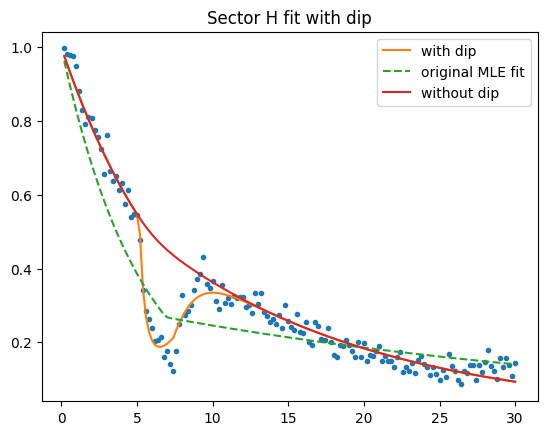

In [119]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.18, 0.05, 6, 10, 7, 3, 10.0, 5.0]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 15),       # t_e
    (0.1, 8),      # delta
    (0.01, 20),    # eps0
    (0.1, 30)      # tau
]
result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x


plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

In [ ]:
print(mu_lb, mu_ub, K, m, t_e, delta, eps0, tau)


# Parameters for H:
# Original
# 0.190143914, 0.028016019, 6.93767599, 100
# With dip
# 0.07329040625608742 0.12339604116636015 4.785811837559308 21.559812127096905 7.399999998522732 2.2494996327925953 2.851388600217068 1.2805374525422937

0.07329040625608742 0.12339604116636015 4.785811837559308 21.559812127096905 7.399999998522732 2.2494996327925953 2.851388600217068 1.2805374525422937


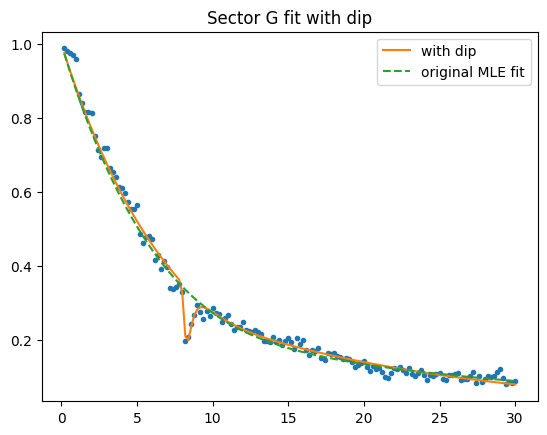

In [115]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'G')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'G')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.18, 0.05, 6, 10, 7, 1, 8.0, 1.0]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 15),       # t_e
    (0.1, 8),      # delta
    (0.01, 20),    # eps0
    (0.1, 30)      # tau
]
result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x


plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
plt.plot(ages, model_survival_curve_hill(ages, 0.13660027, 0.03574423, 12.39113424, 4.14356328), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector G fit with dip')
plt.legend()
plt.show()

In [117]:
print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

# 0.13660027, 0.03574423, 12.39113424, 4.14356328
# 0.05676347079907682 0.1304523009246678 11.14637115477578 10.209897058167362 8.453378775474212 0.47314192060654897 8.112547911189777 0.3329605479574186

mu_lb: 0.05676347079907682, mu_ub: 0.1304523009246678, K: 11.14637115477578, m: 10.209897058167362, t_e: 8.453378775474212, delta: 0.47314192060654897, eps0: 8.112547911189777, tau: 0.3329605479574186


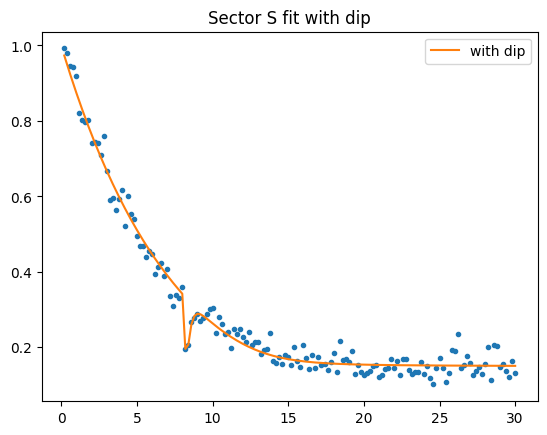

In [120]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'S')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'S')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.18, 0.05, 6, 10, 7, 1, 8.0, 1.0]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 15),       # t_e
    (0.1, 8),      # delta
    (0.01, 20),    # eps0
    (0.1, 30)      # tau
]
result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x


plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.13660027, 0.03574423, 12.39113424, 4.14356328), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector S fit with dip')
plt.legend()
plt.show()

In [121]:
print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

mu_lb: 0.0008503261306282783, mu_ub: 0.1342470173536474, K: 13.687129753253066, m: 8.603838493745096, t_e: 8.392257132396269, delta: 0.3922571239498001, eps0: 8.79892129755383, tau: 0.2379215375535585
